# Using lumped elements in Tidy3D simulations

This notebook presents a demonstration of `Tidy3D`s [LinearLumpedElement](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LinearLumpedElement.html) feature, designed for modeling various linear lumped circuit elements within `Tidy3D` simulations, including resistors, inductors, and capacitors.

We will perform a simulation of a terminated parallel-strip transmission line, employing the [LinearLumpedElement](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.LinearLumpedElement.html) to represent the load. This example is adapted from [1]. While not essential for this tutorial, gaining some familiarity with the [TerminalComponentModeler](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.TerminalComponentModeler.html), could be beneficial, as it is utilized here for extracting scattering parameters.

As an additional optional component of this tutorial, we will explore the creation of an admittance transfer function and a circuit diagram using the [lcapy](https://lcapy.readthedocs.io/en/latest/index.html) Python package. Should this be of interest, please refer to the provided link for installation details.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.plugins.microwave as mw
import tidy3d.plugins.mode as mode
import tidy3d.plugins.smatrix as smatrix
from tidy3d.plugins.mode import web

# We set the logging level to "ERROR". Otherwise there are numerous warnings due to the proximity of the structure to PML boundaries.
td.config.logging_level = "ERROR"

In [2]:
# Introduce a scaling factor to easily convert from mills to microns
mill = 25.4  # one millionth of an inch is 25.4 microns

# Media present
substrate_med = td.Medium(permittivity=2.2)
pec = td.PEC

# Simulation is from 1 to 50 GHz
fstart = 1e9
fstop = 50e9
freqs = np.linspace(fstart, fstop, 1001)
fwidth = fstop - fstart
# Choose 25 GHz as a rough central wavelength for determining padding for PMLs
freq0 = 25e9
wavelength0 = td.C_0 / freq0
# Parameterize the parallel-strip transmission line using parameters from [1].
strip_height = 16 * mill
strip_width = 8 * mill
strip_thickness = 4 * mill
tline_length = 240 * mill

In [3]:
# Here we create the main transmission line structure along with a substrate structure that is sandwiched between the two strips.
strip = td.Structure(
    geometry=td.Box(center=(0, strip_height+strip_thickness/2, 0), size=(tline_length, strip_thickness, strip_width)),
    medium=pec,
    name="strip"
)

strip2 = td.Structure(
    geometry=td.Box(center=(0, -strip_thickness/2, 0), size=(tline_length, strip_thickness, strip_width)),
    medium=pec,
    name="strip2"
)

substrate = td.Structure(
    geometry=td.Box(center=(0, strip_height/2, 0), size=(tline_length, strip_height, strip_width)),
    medium=substrate_med,
    name="substrate"
)

# PML wavelength at 25 GHz
wl_pml = wavelength0

# Quarter wavelength (at 25 GHz) padding on each side
simx = tline_length + wl_pml / 2
simy = strip_height + wl_pml / 2
simz = strip_width + wl_pml / 2

boundary_spec = td.BoundarySpec(
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary.pml(),
)
# This monitor will be used to record the fields along the propagation axis of the transmission line.
prop_mon = td.FieldMonitor(
    center = (0, strip_height/2,0),
    size = (simx, 0, simz),
    freqs=[fstart, freq0, fstop],
    name="prop"
)

## RL Series Network

Before we can create the simulation object, we need to define the lumped element. Each lumped element is associated with a `Box` and a network. The network describes the intended voltage-current relationship, and the box describes the location and size of the lumped element in the `Tidy3D` simulation.

Let's start by using a simple RL network composed of a resistor in series with an inductor.

<img src="img/RL_series_schematic.png" width="300" alt="Series RL network">

In [4]:
# First example is a simple RL series network
Rval = 75
Lval = 1e-9

# The RLCNetwork can model either a single resistor, inductor, or capacitor, as well as, 
# simple series or parallel combinations of these circuit elements.
RLC = td.RLCNetwork(
    resistance=Rval, #units are Ohms
    inductance=Lval, #units are Henries
    network_topology="series"
)
# The LinearLumpedElement models the network as a thin sheet with an equivalent medium that
# results in the same voltage-current relationship as the desired network.
# In this case, we are using the element to terminate a transmission line, so we ensure that it
# is located at the end of the transmission line, with the proper width and height 
lumped_element = td.LinearLumpedElement(
    network=RLC,
    center=(tline_length / 2, strip_height / 2, 0),
    size=(0, strip_height, strip_width),
    name="network",
    voltage_axis=1,
)

Next, we will create a simulation object incorporating the structures we've constructed, as well as the specified boundary conditions, monitors, and the lumped element. Beyond plotting the scattering parameters, we aim to plot the impedance of the lumped element to ensure it is functioning as expected, utilizing data derived from the FDTD simulation. To facilitate this computation, we will employ the convenience method `to_monitor` to establish a monitor around the lumped element. This monitor will enable precise computation of both voltage and current.

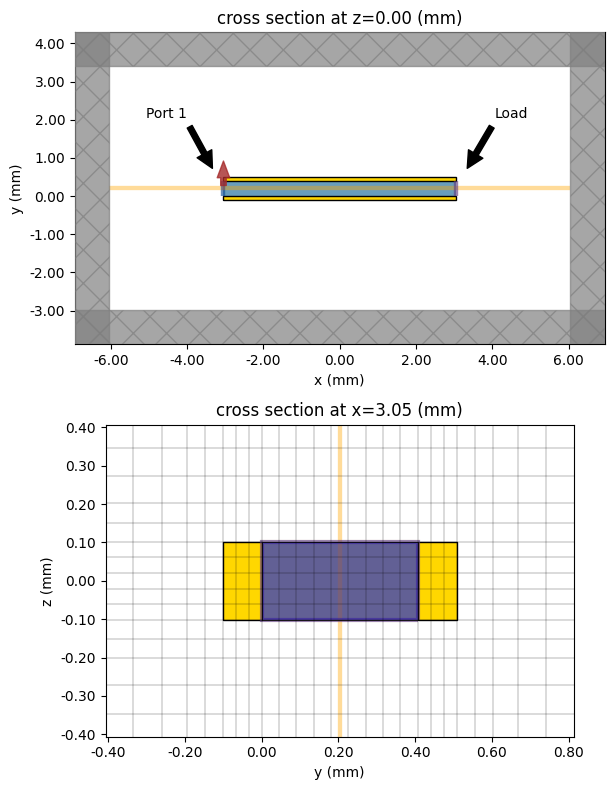

In [5]:
# Now we create the simulation and include the definition of the lumped element.
sim = td.Simulation(
    center=(0, strip_height/2, 0),
    size=(simx, simy, simz),
    boundary_spec=boundary_spec,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=80, wavelength=3000),
    lumped_elements=[lumped_element],
    structures=[substrate, strip, strip2],
    # Add monitor around lumped element to enable computation of voltage, current, and impedance.
    monitors=[prop_mon, lumped_element.to_monitor(freqs=freqs)],
    # The source will be added by the TerminalComponentModeler
    sources=[],
    run_time= 50*(tline_length/td.C_0),
    plot_length_units="mm", # This option will make plots default to units of millimeters.
)
# The next step is to setup a LumpedPort for the TerminalComponentModeler, which is needed for extracting scattering parameters
# as well as providing a source for the simulation.
port1 = smatrix.LumpedPort(
    voltage_axis=1,
    size=(0,strip_height,strip_width),
    center=(-tline_length/2, strip_height/2, 0),
    num_grid_cells=5,
    name="port_1",
)
# Finally, we combine the base simulation with the LumpedPort in the TerminalComponentModeler, which will enable use
# to compute scattering parameters as well as retrieve any other desired data from the simulation.
modeler = smatrix.TerminalComponentModeler(
    simulation = sim,
    freqs = freqs,
    ports = [port1],
    verbose = True,
    remove_dc_component=False, # Include DC component for more accuracy at low frequencies
)
# Before running the solver, we plot the created structure along its propagation direction. We also plot the cross-section 
# of the structure at the terminated end of the transmission line, which includes the location of the lumped element.
sim_temp = list(modeler.sim_dict.values())[0]
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(10, 8))
sim_temp.plot(z = 0*mill, ax=ax1)
sim_temp.plot(x = tline_length/2, ax=ax2)
sim_temp.plot_grid(x = tline_length/2, ax=ax2, vlim=[-2*strip_width, 2*strip_width], hlim=[-strip_height, 2*strip_height])
# Add arrows that indicate locations of the Port and the load
ax1.annotate("Port 1", xy=(-tline_length/2 - 10*mill, strip_height + 10*mill), xytext=(-tline_length/1.2,strip_width*10),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax1.annotate("Load", xy=(tline_length/2 + 10*mill, strip_height + 10*mill), xytext=(tline_length/1.5,strip_width*10),
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

### Run Tidy3D

In [6]:
# In this step, the Tidy3D solver is launched and the results are gathered.
s_matrix = modeler.run()
batch_data = modeler.batch_data

Output()

16:20:56 EST Started working on Batch containing 1 tasks.

16:21:04 EST Maximum FlexCredit cost: 0.025 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

16:21:25 EST Batch complete.

Output()

First we plot the dominant components of the electric and magnetic field within the transmission line.

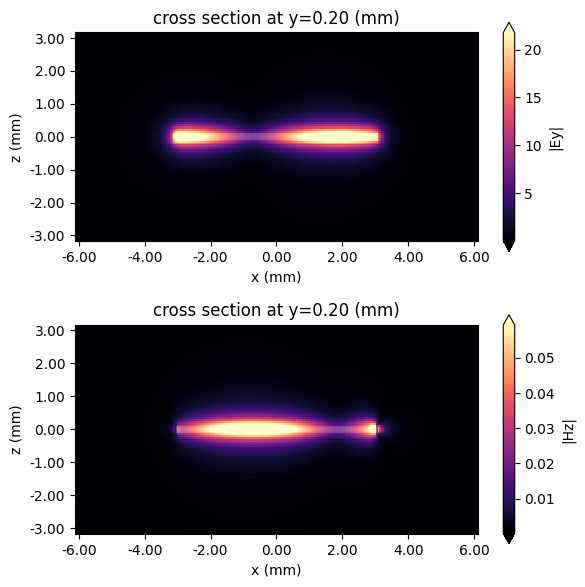

In [7]:
sim_data = batch_data["smatrix_port_1"]

f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(6, 6))
sim_data.plot_field(
    field_monitor_name="prop", field_name="Ey", val="abs", f=freq0, ax=ax1
)
sim_data.plot_field(
    field_monitor_name="prop", field_name="Hz", val="abs", f=freq0, ax=ax2
)
plt.show()

From the plots of the fields we confirm that the transmission line is correctly guiding the the electromagnetic field. In addition, we observe a standing wave at this frequency which indicates that the load is not perfectly matched to the characteristic impedance of the transmission line. This is expected, since the transmission line would need to be terminated by a load with a real impedance to avoid reflections.

### Computing the Reflection Coefficient Using Transmission Line Theory

The next step will be plotting the scattering parameter associated with the reflection coefficient. In order to validate this result, we will first use transmission line theory to obtain a reference value. To compute the reflection coefficient using transmission line theory, we need the characteristic impedance and the phase constant $\beta$ of the transmission line mode. Both quantities can be computed from the eigenmode of the transmission line. The phase constant $\beta$ is found from the computed effective index. The characteristic impedance can be computed using the [ImpedanceCalculator](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.microwave.ImpedanceCalculator.html#tidy3d.plugins.microwave.ImpedanceCalculator), see the associated [tutorial notebook](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/CharacteristicImpedanceCalculator.html) for a detailed description of its usage.

In [8]:
# The eigenmode associated with the tranmission line is computed at the central frequency 25 GHz
mode_spec = td.ModeSpec(num_modes=1, target_neff=2.2)
mode_plane = td.Box(center = sim.center, size = (0, simy, simz))
mode_solver = mode.ModeSolver(simulation=sim_temp, plane=mode_plane, mode_spec=mode_spec, freqs=[freq0])
mode_data = mode_solver.solve()
mode_data = web.run(mode_solver)
# Convert the effective refractive index into an effective permittivity
er_eff = (np.real(mode_data.n_eff.values[0]))**2

16:21:29 EST Mode solver created with                                           
             task_id='fdve-f2aad1e9-30d9-41ff-8e47-d4405d8415e8',               
             solver_id='mo-7e24b712-8414-4a2a-9283-da3c1cee7c9b'.

Output()

Output()

16:21:31 EST Mode solver status: queued

16:22:16 EST Mode solver status: running

16:22:30 EST Mode solver status: success

Output()

Next, we define path integrals in the mode plane that will be used to compute voltage, current, and, ultimately, the characteristic impedance of the transmission line mode.

In [9]:
# Define a path integral along the y axis that will be used to compute voltage.
V_integral = mw.VoltageIntegralAxisAligned(
    center=(0, strip_height / 2, 0),
    size=(0, strip_height, 0),
    snap_path_to_grid=True,
    extrapolate_to_endpoints=True,
    sign="+",
)
# Define a path integral around the upper signal conductor that will be used to compute current.
I_integral = mw.CurrentIntegralAxisAligned(
    center=(0, strip_height + strip_thickness / 2, 0),
    size=(0, strip_thickness * 3, strip_width * 3),
    snap_contour_to_grid=True,
    extrapolate_to_endpoints=True,
    sign="+",
)
# Pass these definitions to the ImpedanceCalculator
impedance_calc = mw.ImpedanceCalculator(
    voltage_integral=V_integral, current_integral=I_integral
)
characteristic_impedance_data = impedance_calc.compute_impedance(mode_data)
# Select the real part of the only value in the array
characteristic_impedance = np.real(characteristic_impedance_data.values[0])

# Define a helper function that computes the reflection coefficient using transmission line theory.
def compute_Gamma_from_transmission_line_theory(ZL, Z0, er_eff):
    beta = 2*np.pi*freqs/td.C_0*np.sqrt(er_eff) # Phase constant of the transmission line.
    # Calculate impedance seen at the input of the transmission line
    # Equation 2.44 from [2]
    Zin = Z0*(ZL + complex(0,1)*Z0*np.tan(beta*tline_length))/(Z0 + complex(0,1)*ZL*np.tan(beta*tline_length))
    # Calculate the reflection coefficient using the reference impedance associated with the port.
    Zport = port1.impedance
    # Equation 2.72 from [2] to account for generator and load mismatch.
    Gamma = (Zin-Zport)/(Zin+Zport)
    return Gamma


Next, we plot the extracted scattering parameter, which is associated with the reflection coefficient.

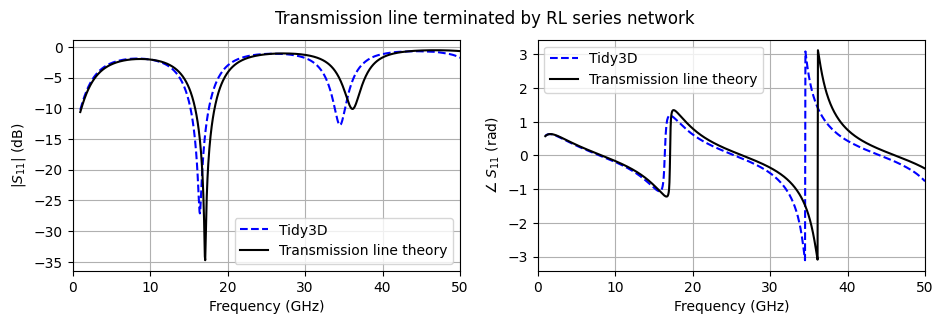

In [10]:
# Tidy3D uses the physics convention for time-harmonic fields,
# so we take the conjugate in order to switch to the engineering convention.
load_impedance = np.conj(lumped_element.impedance(freqs))
Gamma = compute_Gamma_from_transmission_line_theory(load_impedance, characteristic_impedance, er_eff)

# Get S11 data
freq = s_matrix.f / 1e9
S11 = s_matrix.isel(port_out=0, port_in=0).values.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
fig.suptitle("Transmission line terminated by RL series network")
ax1.plot(
    s_matrix.f / 1e9,
    20 * np.log10(np.abs(S11)),
    "--b",
    label="Tidy3D"
)
ax1.plot(
    freqs / 1e9,
    20 * np.log10(np.abs(Gamma)),
    "-k",
    label="Transmission line theory"
)
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel(r"$|S_{11}|$ (dB)")
ax1.set_xlim([0, 50])
ax1.grid()
ax1.legend()

ax2.plot(
    s_matrix.f / 1e9,
    -np.angle(S11), #Follow engineering convention exp(j omega t)
    "--b",
    label="Tidy3D"
)
ax2.plot(
    freqs / 1e9,
    np.angle(Gamma),
    "-k",
    label="Transmission line theory"
)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel(r"$\angle~S_{11}$ (rad)")
ax2.set_xlim([0, 50])
ax2.grid()
ax2.legend()
plt.show()

We observe good agreement with the simple transmission line model, especially at low frequencies.

As an additional validation step, we calculate the impedance of the lumped element and relate it back to the intended impedance of the RL series network. The impedance is calculated via Ohm's Law by computing the voltage across the lumped element along with the current flowing through the element using the path integral tools from the `microwave` plugin.

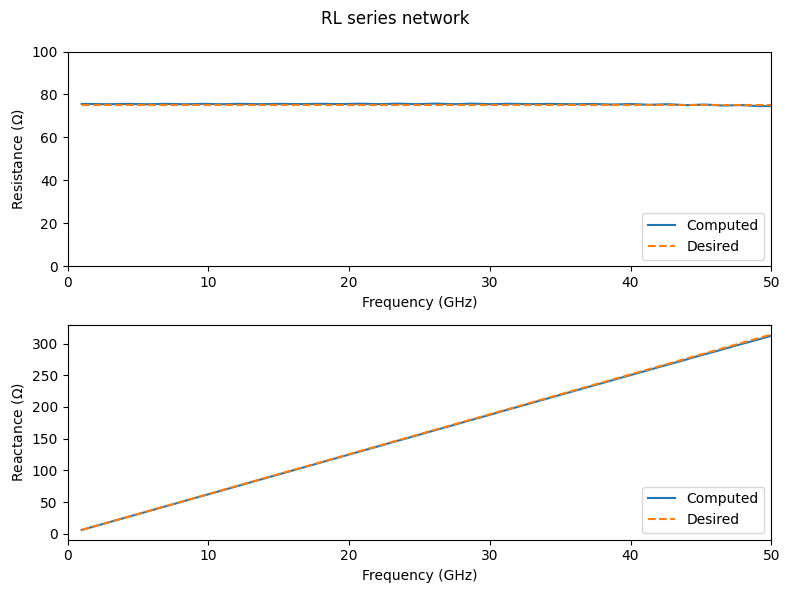

In [11]:
# Get the monitor data associated the lumped element
vi_mon_data = sim_data[lumped_element.monitor_name]
# Setup voltage and current path integrals automatically around the lumped element. 
voltage_integral, current_integral = mw.path_integrals_from_lumped_element(lumped_element, sim_data.simulation.grid)
# Compute the voltage and current using the path integral tools and the frequency-domain field data.
V = voltage_integral.compute_voltage(vi_mon_data)
I = current_integral.compute_current(vi_mon_data)
# Apply Ohm's law to retrieve impedance
impedance = V/I
resistance = np.real(impedance).values
reactance = -np.imag(impedance).values # Change of sign, since Tidy3D uses the physics convention for time-harmonic fields (exp(-j omega t))
# Here we use the convenience methods from the lumped element to compute the exact impedance of the modeled network.
ideal_impedance = lumped_element.impedance(freqs=freqs)
ideal_resistance = np.real(ideal_impedance)
ideal_reactance = -np.imag(ideal_impedance) # Change of sign, since Tidy3D uses the physics convention for time-harmonic fields (exp(-j omega t))

# Plot the results for visual comparison
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(8, 6))
f.suptitle("RL series network")
ax1.plot(freqs / 1e9, resistance, label="Computed")
ax1.plot(freqs / 1e9, ideal_resistance,"--", label="Desired")
ax1.set_ylabel(r"Resistance ($\Omega$)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 100)
ax1.legend(loc="lower right")
ax2.plot(freqs / 1e9, reactance, label="Computed")
ax2.plot(freqs / 1e9, ideal_reactance,"--", label="Desired")
ax2.set_ylabel(r"Reactance ($\Omega$)")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_xlim(0, 50)
ax2.legend(loc="lower right")
plt.show()

At low frequencies, we obtain remarkable agreement with the initially targeted impedance. However, at high frequencies, the computed impedance deviates from the intended value. This discrepancy arises because the path integral used for the current calculation does not include the effect of the displacement current, which becomes stronger as the frequency increases. This error can be reduced by increasing the grid resolution, since the path integral will enclose a smaller area, while still enclosing the same current flowing through the lumped element.

## Seven Element Network

Now, let's switch to a more complicated network consisting of seven circuit elements, as detailed in Chapter 15 of [1]. For this example, we will need to describe the network using its admittance transfer function in the Laplace domain. The transfer function is a rational expression, which is described by the monomial coefficients of its numerator and denominator, see [AdmittanceNetwork](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.AdmittanceNetwork.html#tidy3d.AdmittanceNetwork).

<img src="img/fourth_order_network_schematic.png" width="750" alt="Fourth Order network">

Generating transfer function using 'lcapy' ...
Suggestion: add a constraint between nodes (9, 12, 13, 11, 14, 15) and (16, 10) for vertical graph


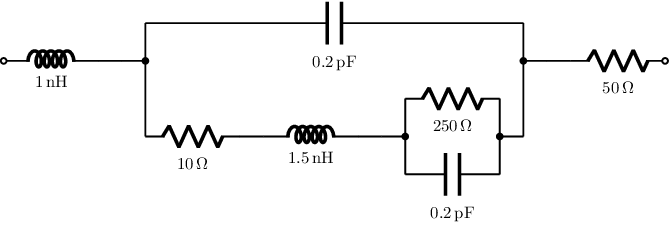

In [12]:
# Example network from Sec 15.9.6 [1] 
L1 = 1e-9
L2 = 1.5e-9
C1 = 0.2e-12
C2 = 0.2e-12
R1 = 10
R2 = 250
R3 = 50

# If you have installed lcapy, the transfer function will be automatically generated using a simple description of the network.
# Otherwise, the precomputed transfer function coefficients will be used.
try:
    from lcapy import R, C, L, s
    print("Generating transfer function using 'lcapy' ...")
    # Create the 4th order network using 'lcapy'
    # The network is described by adding each of the elements in series and parallel
    network = L(L1) + (C(C1) | (R(R1) + L(L2) + (R(R2) | C(C2)))) + R(R3)
    # Can also get `lcapy` to draw the network
    network.draw(layout="horizontal", scale=0.4)
    lca_a = network.Y(s).N.coeffs()
    lca_b = network.Y(s).D.coeffs()
    # Reverse order of coefficients
    a = tuple(np.flip(lca_a.fval))
    b = tuple(np.flip(lca_b.fval))

except ModuleNotFoundError:
    print("Skipping steps involving 'lcapy' package ...")
    # Manually derived admittance transfer function for network
    a = [
        1,
        C1 * R1 + C1 * R2 + C2 * R2,
        C1 * C2 * R1 * R2 + C1 * L2,
        C1 * C2 * L2 * R2,
        0,
    ]
    b = [
        R1 + R2 + R3,
        C1 * R1 * R3 + C1 * R2 * R3 + C2 * R1 * R2 + C2 * R2 * R3 + L1 + L2,
        C1 * C2 * R1 * R2 * R3 + C1 * L1 * R1 + C1 * L1 * R2
        + C1 * L2 * R3 + C2 * L1 * R2 + C2 * L2 * R2,
        C1 * C2 * L1 * R1 * R2 + C1 * C2 * L2 * R2 * R3 + C1 * L1 * L2,
        C1 * C2 * L1 * L2 * R2,
    ]

# With the admittance transfer function in hand, we can construct the AdmittanceNetwork
fourth_order_network = td.AdmittanceNetwork(a=a, b=b)
# We create an updated copy of the lumped element from the previous simulation.
lumped_element = lumped_element.updated_copy(network=fourth_order_network)
# Instead of repeating all of the previous steps to build the Simulation and TerminalComponentModeler,
# we create an updated copy of the modeler which includes the newly created lumped element.
modeler = modeler.updated_copy(lumped_elements=[lumped_element], path="simulation")

### Run Tidy3D

In [13]:
# In this step, the Tidy3D solver is launched and the results are gathered.
s_matrix = modeler.run(modeler.path_dir)
batch_data = modeler.batch_data

Output()

16:22:34 EST Started working on Batch containing 1 tasks.

16:22:40 EST Maximum FlexCredit cost: 0.025 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

16:23:02 EST Batch complete.

Output()

We again plot the scattering parameter for the transmission line terminated by this new load, along with the value predicted by transmission line theory.

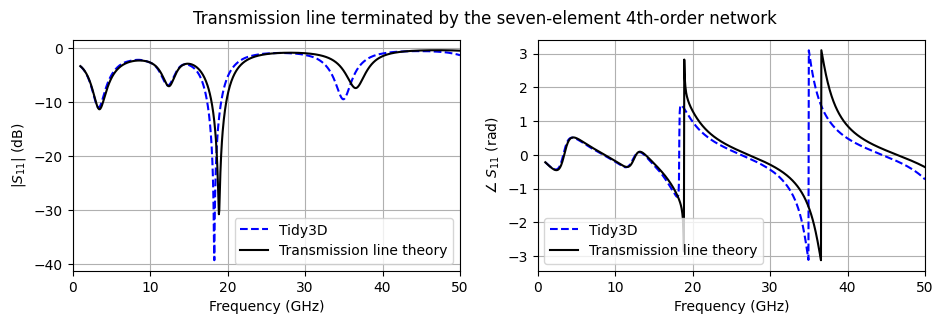

In [14]:
# Tidy3D uses the physics convention for time-harmonic fields,
# so we take the conjugate in order to switch to the engineering convention.
load_impedance = np.conj(lumped_element.impedance(freqs))
Gamma = compute_Gamma_from_transmission_line_theory(load_impedance, characteristic_impedance, er_eff)

# Get the S11 data
freq = s_matrix.f / 1e9
S11 = s_matrix.isel(port_out=0, port_in=0).values.flatten()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 3))
fig.suptitle("Transmission line terminated by the seven-element 4th-order network")
ax1.plot(
    s_matrix.f / 1e9,
    20 * np.log10(np.abs(S11)),
    "--b",
    label="Tidy3D"
)
ax1.plot(
    freqs / 1e9,
    20 * np.log10(np.abs(Gamma)),
    "-k",
    label="Transmission line theory"
)
ax1.set_xlabel("Frequency (GHz)")
ax1.set_ylabel(r"$|S_{11}|$ (dB)")
ax1.set_xlim([0, 50])
ax1.grid()
ax1.legend()
ax2.plot(
    s_matrix.f / 1e9,
    -np.angle(S11), #Follow engineering convention exp(j omega t)
    "--b",
    label="Tidy3D"
)
ax2.plot(
    freqs / 1e9,
    np.angle(Gamma),
    "-k",
    label="Transmission line theory"
)
ax2.set_xlabel("Frequency (GHz)")
ax2.set_ylabel(r"$\angle~S_{11}$ (rad)")
ax2.set_xlim([0, 50])
ax2.grid()
ax2.legend()
plt.show()

We again observe good agreement between the full-wave simulation and the transmission line model.

As a last step, we validate that the lumped element is operating as expected by directly computing its impedance and comparing it to the intended impedance, which is associated with the original network.

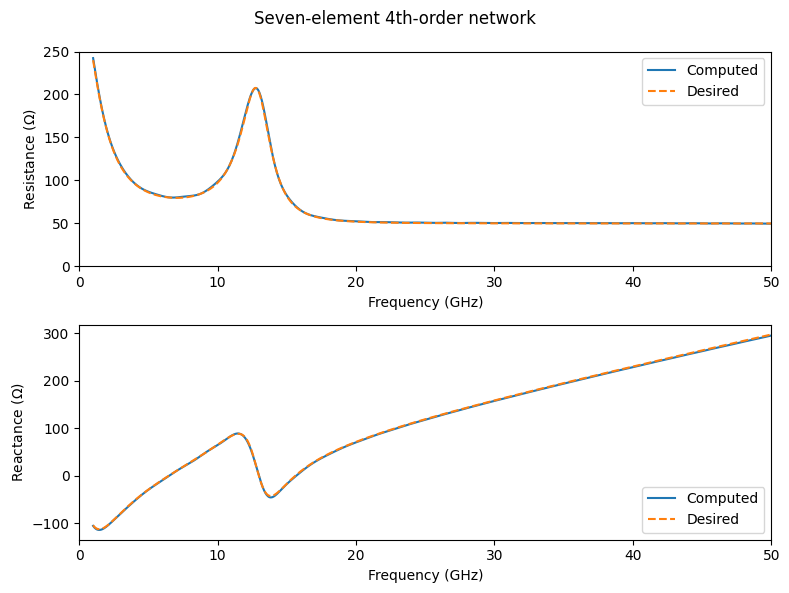

In [15]:
# Retrieve the simulation data
sim_data = batch_data["smatrix_port_1"]
# Get the monitor data associated the lumped element
vi_mon_data = sim_data[lumped_element.monitor_name]
# Setup voltage and current path integrals automatically around the lumped element. 
voltage_integral, current_integral = mw.path_integrals_from_lumped_element(lumped_element, sim_data.simulation.grid)
# Compute the voltage and current using the path integral tools and the frequency-domain field data.
V = voltage_integral.compute_voltage(vi_mon_data)
I = current_integral.compute_current(vi_mon_data)
# Apply Ohm's law to retrieve impedance
impedance = V/I
resistance = np.real(impedance).values
reactance = -np.imag(impedance).values # Change of sign, since Tidy3D uses the physics convention for time-harmonic fields (exp(-j omega t))
# Here we use the convenience methods from the lumped element to compute the intended impedance of the modeled network.
ideal_impedance = lumped_element.impedance(freqs=freqs)
ideal_resistance = np.real(ideal_impedance)
ideal_reactance = -np.imag(ideal_impedance) # Change of sign, since Tidy3D uses the physics convention for time-harmonic fields (exp(-j omega t))

# Plot the results for visual comparison
f, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(8, 6))
f.suptitle("Seven-element 4th-order network")
ax1.plot(freqs / 1e9, resistance, label="Computed")
ax1.plot(freqs / 1e9, ideal_resistance,"--", label="Desired")
ax1.set_ylabel(r"Resistance ($\Omega$)")
ax1.set_xlabel("Frequency (GHz)")
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 250)
ax1.legend(loc="upper right")
ax2.plot(freqs / 1e9, reactance, label="Computed")
ax2.plot(freqs / 1e9, ideal_reactance,"--", label="Desired")
ax2.set_ylabel(r"Reactance ($\Omega$)")
ax2.set_xlabel("Frequency (GHz)")
ax2.set_xlim(0, 50)
ax2.legend(loc="lower right")
plt.show()

## References

[1] A. Taflove and S. C. Hagness, *Computational Electrodynamics The Finite-Difference Time-Domain Method*, Third Edition,	Artech House, 2005.

[2] David M. Pozar, "Microwave Network Analysis" in Microwave Engineering, 4th ed. 2011, ch. 2.